In [107]:
''''In tis main file we do an initial explortation, we clean the data, and perfoirm EDA and vizualisation'''

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import initial_exploration as explo
import data_cleaning as cl

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# Load datasets:
cash_requests = pd.read_csv('project_dataset/extract - cash request - data analyst.csv')
fees = pd.read_csv('project_dataset/extract - fees - data analyst - .csv')

In [109]:
cash_requests.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [110]:
# Inital exploration:
explo.check(cash_requests)

Number of columns: 16 amd rows: 23970

Data types:
id                              int64
amount                        float64
status                         object
created_at                     object
updated_at                     object
user_id                       float64
moderated_at                   object
deleted_account_id            float64
reimbursement_date             object
cash_request_received_date     object
money_back_date                object
transfer_type                  object
send_at                        object
recovery_status                object
reco_creation                  object
reco_last_update               object
dtype: object

Unique values count:
id                            23970
amount                           41
status                            7
created_at                    23970
updated_at                    23970
user_id                       10798
moderated_at                  16035
deleted_account_id             1141
reimbursement_dat

In [111]:
cl.convert_dates(cash_requests, cl.cash_request_date_columns)

# Re-check and ensure correct data types in cash_requests:
cl.ensure_correct_data_types(cash_requests, cl.cash_request_date_columns)

cash_requests.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
1,70,100.0,rejected,2019-12-10,2019-12-11,231.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
2,7,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
3,10,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT
4,1594,100.0,rejected,2020-05-06,2020-05-07,7686.0,2020-05-07,NaN,2020-06-05,NaT,NaT,regular,NaT,NaN,NaT,NaT


In [112]:
explo.check(cash_requests)

Number of columns: 16 amd rows: 23970

Data types:
id                                     int64
amount                               float64
status                              category
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
user_id                              float64
moderated_at                  datetime64[ns]
deleted_account_id                   float64
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
transfer_type                       category
send_at                       datetime64[ns]
recovery_status                     category
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
dtype: object

Unique values count:
id                            23970
amount                           41
status                            7
created_at                      330
updated_at                      401
user_id      

In [113]:
fees.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [114]:
explo.check(fees)

Number of columns: 13 amd rows: 21061

Data types:
id                   int64
cash_request_id    float64
type                object
status              object
category            object
total_amount       float64
reason              object
created_at          object
updated_at          object
paid_at             object
from_date           object
to_date             object
charge_moment       object
dtype: object

Unique values count:
id                 21061
cash_request_id    12933
type                   3
status                 4
category               2
total_amount           2
reason             15149
created_at         21026
updated_at         21061
paid_at            15529
from_date           1084
to_date             1560
charge_moment          2
dtype: int64

This columns apear to be categroical:
 Index(['type', 'status', 'category', 'total_amount', 'charge_moment'], dtype='object')

Unique value count for categorical columns:
type
instant_payment    11099
postpone            77

In [115]:
cl.convert_dates(fees, cl.fees_data_date_columns)

# Re-check and ensure correct data types in cfees:
cl.ensure_correct_data_types(fees, cl.fees_data_date_columns)

fees.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07,2020-10-13,2020-12-17,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09,2020-10-13,2020-12-08,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23,2020-10-23,2020-11-04,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31,2020-10-31,2020-11-19,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06,2020-10-13,2020-11-02,NaT,NaT,after


In [116]:
cl.rename_col(cash_requests, 'id', 'cash_request_id')
data_df = cl.merge_df(cash_requests, fees, 'outer', 'cash_request_id')
data_df = cl.rename_col_xy(data_df)
data_df.head(20)

,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id,type,fee_status,category,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
0,3.0,1.0,canceled,2019-11-19,2020-12-14,47.0,2019-11-20,NaN,2019-12-05,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
1,4.0,100.0,money_back,2019-12-09,2020-11-04,NaN,2019-12-09,1309.0,2019-12-16,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
2,5.0,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
3,6.0,100.0,direct_debit_rejected,2019-12-10,2020-12-18,812.0,2019-12-11,NaN,2020-02-05,2019-12-11,NaT,regular,NaT,pending,2020-03-20,2020-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
4,7.0,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
5,9.0,100.0,money_back,2019-12-10,2020-11-04,430.0,2019-12-11,NaN,2020-01-08,2019-12-11,2020-05-12,regular,NaT,completed,2020-03-20,2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
6,10.0,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
7,11.0,100.0,money_back,2019-12-10,2020-11-04,735.0,2019-12-11,NaN,2019-12-30,2019-12-12,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
8,13.0,100.0,direct_debit_rejected,2019-12-10,2020-11-04,406.0,2019-12-11,NaN,2020-02-05,2019-12-12,NaT,regular,NaT,pending,2020-03-20,2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
9,28.0,100.0,money_back,2019-12-10,2020-11-04,140.0,2019-12-11,NaN,2020-01-08,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN


In [117]:
data_df.sample(10)

,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id,type,fee_status,category,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
19916,16964.0,50.0,money_back,2020-09-20,2020-12-18,NaN,2020-09-20,21574.0,2020-10-13,2020-09-22,2020-10-14,instant,2020-09-27,NaN,NaT,NaT,9236.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 16964,2020-09-25,2020-10-13,NaT,2020-10-13,2020-10-26,after
29230,24139.0,20.0,money_back,2020-10-24,2020-12-18,90754.0,NaT,NaN,2020-11-09,2020-10-25,2020-11-09,instant,2020-10-24,NaN,NaT,NaT,17901.0,postpone,accepted,NaN,5.0,Postpone Cash Request 24139,2020-10-26,2020-10-26,2020-10-26,2020-11-01,2020-11-09,before
12040,11302.0,100.0,money_back,2020-08-07,2020-12-18,6829.0,2020-08-07,NaN,2020-11-02,2020-08-15,2020-11-02,regular,2020-08-14,NaN,NaT,NaT,8195.0,postpone,accepted,NaN,5.0,Postpone Cash Request 11302,2020-09-18,2020-10-13,2020-09-18,2020-10-03,2020-11-02,before
10571,10174.0,100.0,money_back,2020-07-30,2020-12-18,22078.0,2020-07-30,NaN,2020-08-11,2020-08-01,2020-08-11,regular,2020-08-06,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
6019,5999.0,100.0,money_back,2020-06-30,2020-12-18,10522.0,2020-07-01,NaN,2020-08-04,2020-07-03,2020-08-04,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
2153,2214.0,50.0,money_back,2020-05-27,2020-06-11,2102.0,2020-05-27,NaN,2020-06-07,2020-05-28,2020-06-11,regular,NaT,NaN,NaT,NaT,2.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 2214,2020-06-23,2020-10-13,NaT,2020-06-07,2020-06-22,after
30835,25695.0,25.0,money_back,2020-10-28,2020-12-18,96017.0,NaT,NaN,2020-11-06,2020-10-30,2020-11-06,instant,2020-10-28,NaN,NaT,NaT,19239.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 25695,2020-10-28,2020-10-28,2020-11-06,NaT,NaT,after
2015,2084.0,100.0,money_back,2020-05-21,2020-06-10,160.0,2020-05-21,NaN,2020-06-01,2020-05-22,2020-06-10,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
22699,18861.0,100.0,rejected,2020-10-02,2020-10-02,59329.0,2020-10-02,NaN,2020-10-16,NaT,NaT,instant,2020-10-09,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
25542,21057.0,100.0,money_back,2020-10-14,2020-12-18,66788.0,NaT,NaN,2020-10-26,2020-10-15,2020-10-26,instant,2020-10-14,NaN,NaT,NaT,13393.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 21057,2020-10-14,2020-10-14,2020-10-26,NaT,NaT,after


In [118]:
cl.rename_col(data_df, 'id', 'id_fee')
cl.clean_text_column(data_df, "reason")
explo.check(data_df)

Number of columns: 28 amd rows: 32098

Data types:
cash_request_id                      float64
amount                               float64
CR_status                           category
CR_created_at                 datetime64[ns]
CR_updated_at                 datetime64[ns]
user_id                              float64
moderated_at                  datetime64[ns]
deleted_account_id                   float64
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
transfer_type                       category
send_at                       datetime64[ns]
recovery_status                     category
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
id_fee                               float64
type                                category
fee_status                          category
category                            category
total_amount                         float64
reas

In [119]:
data_df = cl.remove_nan(data_df, "cash_request_id")
explo.check_null(data_df)

4 rows were removed

Count of null values:
cash_request_id                   0
amount                            0
CR_status                         0
CR_created_at                     0
CR_updated_at                     0
user_id                        2572
moderated_at                  10335
deleted_account_id            29521
reimbursement_date                0
cash_request_received_date     7945
money_back_date                8177
transfer_type                     0
send_at                        9724
recovery_status               24894
reco_creation                 24894
reco_last_update              24894
id_fee                        11037
type                          11037
fee_status                    11037
category                      29898
total_amount                  11037
reason                        11037
fee_created_at                11037
fee_updated_at                11037
paid_at                       16656
from_date                     24328
to_date              

In [120]:
data_df = cl.drop_col(data_df, ["id_fee", "category"])
data_df.head(10)

,cash_request_id,amount,CR_status,CR_created_at,CR_updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,type,fee_status,total_amount,reason,fee_created_at,fee_updated_at,paid_at,from_date,to_date,charge_moment
0,3.0,1.0,canceled,2019-11-19,2020-12-14,47.0,2019-11-20,NaN,2019-12-05,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
1,4.0,100.0,money_back,2019-12-09,2020-11-04,NaN,2019-12-09,1309.0,2019-12-16,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
2,5.0,100.0,rejected,2019-12-10,2019-12-11,804.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
3,6.0,100.0,direct_debit_rejected,2019-12-10,2020-12-18,812.0,2019-12-11,NaN,2020-02-05,2019-12-11,NaT,regular,NaT,pending,2020-03-20,2020-12-18,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
4,7.0,100.0,rejected,2019-12-10,2019-12-11,191.0,2019-12-11,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
5,9.0,100.0,money_back,2019-12-10,2020-11-04,430.0,2019-12-11,NaN,2020-01-08,2019-12-11,2020-05-12,regular,NaT,completed,2020-03-20,2020-05-12,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
6,10.0,99.0,rejected,2019-12-10,2019-12-18,761.0,2019-12-18,NaN,2020-01-09,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
7,11.0,100.0,money_back,2019-12-10,2020-11-04,735.0,2019-12-11,NaN,2019-12-30,2019-12-12,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
8,13.0,100.0,direct_debit_rejected,2019-12-10,2020-11-04,406.0,2019-12-11,NaN,2020-02-05,2019-12-12,NaT,regular,NaT,pending,2020-03-20,2020-03-31,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN
9,28.0,100.0,money_back,2019-12-10,2020-11-04,140.0,2019-12-11,NaN,2020-01-08,NaT,NaT,regular,NaT,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN


In [121]:
explo.check_null(data_df)

Count of null values:
cash_request_id                   0
amount                            0
CR_status                         0
CR_created_at                     0
CR_updated_at                     0
user_id                        2572
moderated_at                  10335
deleted_account_id            29521
reimbursement_date                0
cash_request_received_date     7945
money_back_date                8177
transfer_type                     0
send_at                        9724
recovery_status               24894
reco_creation                 24894
reco_last_update              24894
type                          11037
fee_status                    11037
total_amount                  11037
reason                        11037
fee_created_at                11037
fee_updated_at                11037
paid_at                       16656
from_date                     24328
to_date                       24328
charge_moment                 11037
dtype: int64


In [122]:
frames = cl.selecting_data_types(data_df)
num = frames[1]
cat = frames[0]
date = frames[2]

In [123]:
num.head()

,amount
0,1.0
1,100.0
2,100.0
3,100.0
4,100.0


In [124]:
explo.check_null(num)

Count of null values:
amount    0
dtype: int64


In [125]:
cat.head()

,CR_status,transfer_type,recovery_status,type,fee_status,reason,charge_moment,total_amount
0,canceled,regular,NaN,NaN,NaN,NaN,NaN,NaN
1,money_back,regular,NaN,NaN,NaN,NaN,NaN,NaN
2,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN
3,direct_debit_rejected,regular,pending,NaN,NaN,NaN,NaN,NaN
4,rejected,regular,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
explo.check_null(cat)

Count of null values:
CR_status              0
transfer_type          0
recovery_status    24894
type               11037
fee_status         11037
reason             11037
charge_moment      11037
total_amount       11037
dtype: int64


In [127]:
date.head()

,CR_created_at,CR_updated_at,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,send_at,reco_creation,reco_last_update,fee_created_at,fee_updated_at,paid_at,from_date,to_date
0,2019-11-19,2020-12-14,2019-11-20,2019-12-05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2019-12-09,2020-11-04,2019-12-09,2019-12-16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-12-10,2020-12-18,2019-12-11,2020-02-05,2019-12-11,NaT,NaT,2020-03-20,2020-12-18,NaT,NaT,NaT,NaT,NaT
4,2019-12-10,2019-12-11,2019-12-11,2020-01-09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [128]:
explo.check_null(date)

Count of null values:
CR_created_at                     0
CR_updated_at                     0
moderated_at                  10335
reimbursement_date                0
cash_request_received_date     7945
money_back_date                8177
send_at                        9724
reco_creation                 24894
reco_last_update              24894
fee_created_at                11037
fee_updated_at                11037
paid_at                       16656
from_date                     24328
to_date                       24328
dtype: int64


In [129]:
# Verify specific date columns' data types in cash_requests:
print("\nCheck data types of date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].dtypes)

# Check for any NaT in date columns:
print("\nCheck NaT (missing values) in date columns:")
print(cash_requests[['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 
                     'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update']].isna().sum())


Check data types of date columns:
created_at                    datetime64[ns]
updated_at                    datetime64[ns]
moderated_at                  datetime64[ns]
reimbursement_date            datetime64[ns]
cash_request_received_date    datetime64[ns]
money_back_date               datetime64[ns]
send_at                       datetime64[ns]
reco_creation                 datetime64[ns]
reco_last_update              datetime64[ns]
dtype: object

Check NaT (missing values) in date columns:
created_at                        0
updated_at                        0
moderated_at                   7935
reimbursement_date                0
cash_request_received_date     7681
money_back_date                7427
send_at                        7504
reco_creation                 20640
reco_last_update              20640
dtype: int64


In [130]:
df_time_between_CR_and_money_back = cl.process_date_columns(date, "CR_created_at", "money_back_date")
df_time_between_CR_and_money_back.head()

,CR_created_at,money_back_date,days_difference
5,2019-12-10,2020-05-12,154
12,2019-12-10,2020-04-12,124
18,2019-12-10,2020-08-23,257
20,2019-12-11,2020-03-14,94
33,2019-12-11,2020-04-16,127


In [131]:
explo.check(df_time_between_CR_and_money_back)

Number of columns: 3 amd rows: 23917

Data types:
CR_created_at      datetime64[ns]
money_back_date    datetime64[ns]
days_difference             int64
dtype: object

Unique values count:
CR_created_at      314
money_back_date    315
days_difference    206
dtype: int64

This columns apear to be categroical:
 Index([], dtype='object')

Unique value count for categorical columns:
Count of null values:
CR_created_at      0
money_back_date    0
days_difference    0
dtype: int64

Count of duplicated values:
18132


In [132]:
df_time_between_fee_created_and_paid_at_date = cl.process_date_columns(date, "fee_created_at", "paid_at")
df_time_between_fee_created_and_paid_at_date.head(20)

,fee_created_at,paid_at,days_difference
1481,2020-07-01,2020-07-01,0
1557,2020-07-15,2020-08-06,22
1590,2020-09-13,2020-12-07,85
1591,2020-10-14,2020-12-07,54
1592,2020-08-15,2020-12-07,114
1593,2020-07-15,2020-12-07,145
1681,2020-06-28,2020-06-28,0
1689,2020-06-23,2020-06-23,0
1710,2020-07-04,2020-07-07,3
1773,2020-07-14,2020-07-14,0


In [133]:
explo.check(df_time_between_fee_created_and_paid_at_date)

Number of columns: 3 amd rows: 15438

Data types:
fee_created_at     datetime64[ns]
paid_at            datetime64[ns]
days_difference             int64
dtype: object

Unique values count:
fee_created_at     132
paid_at            229
days_difference    165
dtype: int64

This columns apear to be categroical:
 Index([], dtype='object')

Unique value count for categorical columns:
Count of null values:
fee_created_at     0
paid_at            0
days_difference    0
dtype: int64

Count of duplicated values:
11315


In [134]:
# We can divide the columns between us and ecah work in a set of columns performing an 
# univariate analysis (frequency plots, box plots, doughnut, histograms   or any other you concider)
#For numercial plots also create report in mean , meadian, std, and arrive to conclusions 

In [135]:
data_df['first_advance_date'] = data_df.groupby('user_id')['CR_created_at'].transform('min')
#create cohort using dates from the first transactions, and grouping all users according to user id.

In [136]:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')
# extracts month and year from the first advance column and converts it to a period format.

In [137]:
data_df['cohort_index'] = (data_df['CR_created_at'].dt.year - data_df['first_advance_date'].dt.year) * 12 + \
                     (data_df['CR_created_at'].dt.month - data_df['first_advance_date'].dt.month) + 1
# finds difference in years between two dates, *12 converts into months.
print(data_df.info()) #check if the cohort column exists

<class 'pandas.core.frame.DataFrame'>
Index: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   cash_request_id             32094 non-null  float64       
 1   amount                      32094 non-null  float64       
 2   CR_status                   32094 non-null  category      
 3   CR_created_at               32094 non-null  datetime64[ns]
 4   CR_updated_at               32094 non-null  datetime64[ns]
 5   user_id                     29522 non-null  float64       
 6   moderated_at                21759 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          32094 non-null  datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             23917 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  category      


In [138]:
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')
data_df.groupby('cohort_month').size()
# extracts the month and year from the list of first advance and creates a new column, 
# cohort month, that shows how many users interacted with the service.


cohort_month
2019-11      13
2019-12    1009
2020-01     383
2020-02     510
2020-03     394
2020-04    1062
2020-05    1930
2020-06    6706
2020-07    5214
2020-08    2135
2020-09    3949
2020-10    6142
2020-11      75
Freq: M, dtype: int64

In [139]:
cohort_table = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()
cohort_table = cohort_table.unstack()
cohort_table = cohort_table.fillna(0)
print(cohort_table)

CR_created_at  2019-11  2019-12  2020-01  2020-02  2020-03  2020-04  2020-05  \
cohort_month                                                                   
2019-11            1.0      1.0      0.0      0.0      0.0      1.0      5.0   
2019-12            0.0    229.0     75.0     46.0     66.0     66.0     79.0   
2020-01            0.0      0.0    101.0     21.0     15.0     35.0     32.0   
2020-02            0.0      0.0      0.0     90.0     48.0     48.0     57.0   
2020-03            0.0      0.0      0.0      0.0     78.0     39.0     42.0   
2020-04            0.0      0.0      0.0      0.0      0.0    229.0    154.0   
2020-05            0.0      0.0      0.0      0.0      0.0      0.0    509.0   
2020-06            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-07            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-08            0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2020-09            0.0      0.0      0.0

In [140]:
cohort_size = data_df.groupby('cohort_month')['user_id'].nunique()
# counts how many unique users belong to each cohort month. 
cohort_size


cohort_month
2019-11       1
2019-12     204
2020-01      90
2020-02      84
2020-03      69
2020-04     212
2020-05     369
2020-06    1338
2020-07    1294
2020-08     656
2020-09    1712
2020-10    4694
2020-11      75
Freq: M, Name: user_id, dtype: int64

In [141]:
# count the number of times each user used the service in each month
cohort_usage = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count()

# each row is a cohort, and each column is a month
cohort_usage = cohort_usage.unstack(fill_value=0)
# Calculate the frequency of service usage by dividing the usage count by cohort size
cohort_usage_frequency = cohort_usage.divide(cohort_size, axis=0)  # Divide usage by cohort size

In [142]:
cohort_usage_percentage = cohort_usage.div(cohort_size, axis=0) * 100
cohort_usage_percentage.fillna(0, inplace=True)


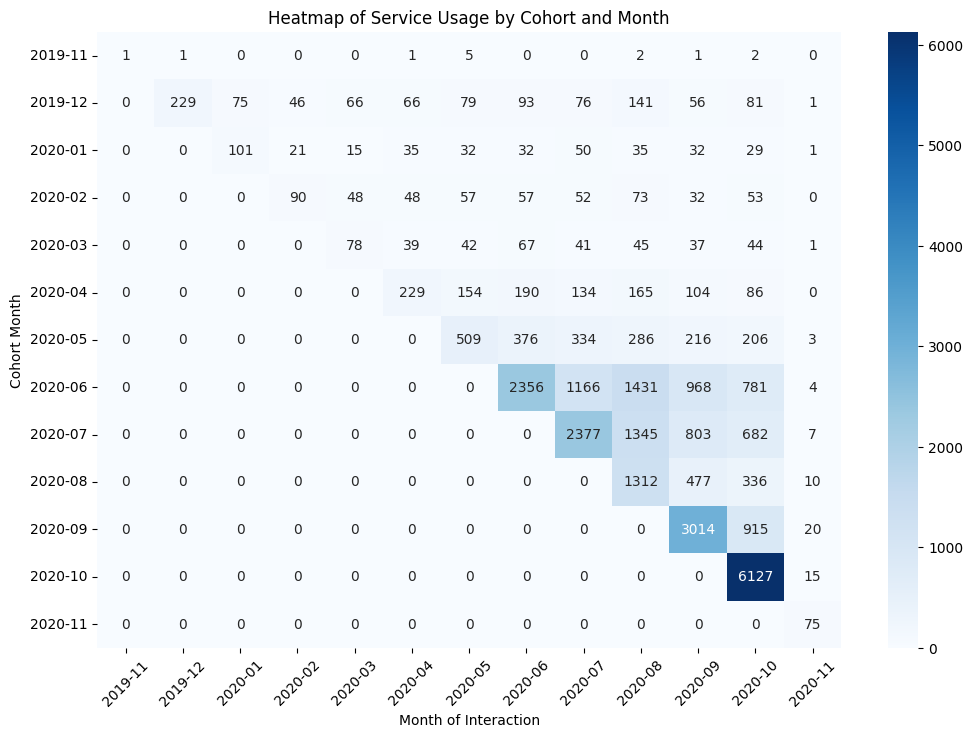

In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Create 'cohort_month' based on the first transaction date
data_df['first_advance_date'] = data_df.groupby('user_id')['CR_created_at'].transform('min')
data_df['cohort_month'] = data_df['first_advance_date'].dt.to_period('M')

# Step 2: Calculate number of new users in each cohort month
new_users = data_df.groupby('cohort_month')['user_id'].nunique()

# Step 3: Calculate total interactions for each cohort month
interactions = data_df.groupby('cohort_month')['user_id'].count()

# Step 4: Calculate the frequency of usage for each cohort
frequency_of_usage = interactions / new_users

# Step 5: Create a DataFrame for the heatmap, where rows are cohort_months and columns are months of interaction
cohort_usage_matrix = data_df.groupby(['cohort_month', data_df['CR_created_at'].dt.to_period('M')])['user_id'].count().unstack()

# Step 6: Fill missing values with 0s
cohort_usage_matrix.fillna(0, inplace=True)

# Step 7: Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_usage_matrix, annot=True, fmt='g', cmap='Blues', cbar=True)

# Add title and labels
plt.title('Heatmap of Service Usage by Cohort and Month')
plt.xlabel('Month of Interaction')
plt.ylabel('Cohort Month')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the heatmap
plt.show()


In [148]:
frequency_by_month = cohort_table.sum(axis=0)  # Sum interactions for all cohorts per month

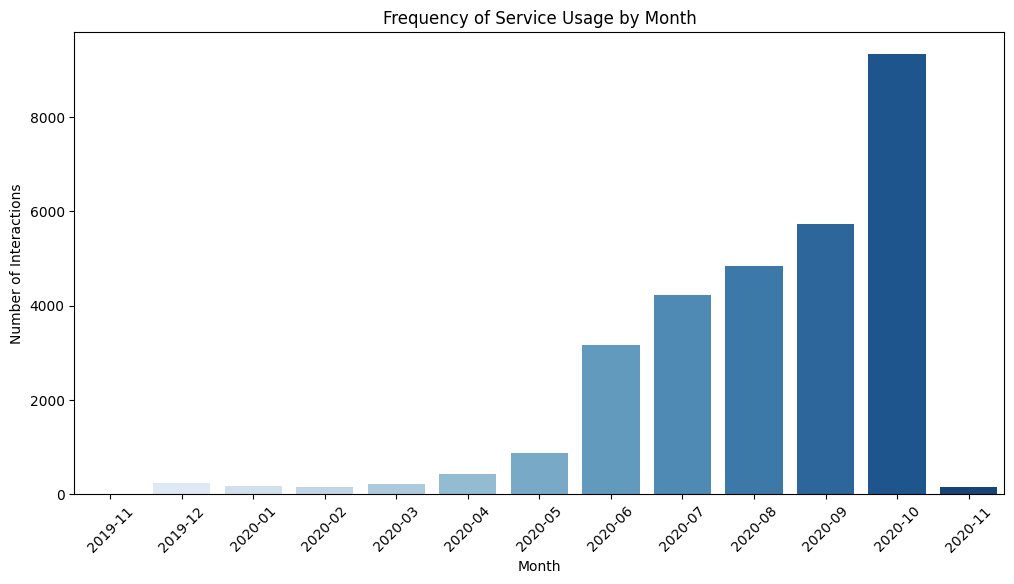

In [149]:
plt.figure(figsize=(12, 6))
sns.barplot(x=frequency_by_month.index.astype(str), y=frequency_by_month.values, palette='Blues')

plt.title('Frequency of Service Usage by Month')
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)  # Rotate month labels for better readability
plt.show()


In [150]:
# Assuming `cohort_table` is a pivot table where:
# - Rows represent cohorts
# - Columns represent months
# - Values represent the number of interactions

# Create a frequency table by summing interactions across cohorts for each month
frequency_table = cohort_table.sum(axis=0)  # Sum of interactions for each month
frequency_table = frequency_table.reset_index()  # Convert to DataFrame for better readability

# Rename the columns for clarity
frequency_table.columns = ['Month', 'Total Interactions']
print(frequency_table)


      Month  Total Interactions
0   2019-11                 1.0
1   2019-12               230.0
2   2020-01               176.0
3   2020-02               157.0
4   2020-03               207.0
5   2020-04               418.0
6   2020-05               878.0
7   2020-06              3171.0
8   2020-07              4230.0
9   2020-08              4835.0
10  2020-09              5740.0
11  2020-10              9342.0
12  2020-11               137.0
